In [1]:
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
import cPickle as pickle
from collections import namedtuple
from pprint import pprint
from wordcloud import WordCloud
from collections import Counter
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [2]:
# Required to read data from pickle file
Transcript = namedtuple('Transcript', ['company', 'ticker', 'date', 'abnormal_return', 'prepared', 'QandA'])

In [3]:
def load_data(filename='../data/transcripts.p'):
    return pickle.load(open(filename, 'r'))

In [4]:
transcripts = load_data()

In [5]:
def sort_transcripts(transcripts):
    
    """ Sorts the transcripts into three groups (High / Mid / Low) based on abnormal return """
    
    tiers = {'High': [],
             'Mid': [],
             'Low': []}

    for transcript in transcripts.values():

        if transcript.abnormal_return >= 0.10:
            tiers['High'].append(transcript)
        elif transcript.abnormal_return >= -0.10:
            tiers['Mid'].append(transcript)
        else:
            tiers['Low'].append(transcript)

    return tiers

In [6]:
tiers = sort_transcripts(transcripts)
for tier in tiers.keys(): print tier, len(tiers[tier])

High 2766
Mid 22482
Low 2898


In [7]:
class TranscriptDoc(object):
    
    """ Custom class used for iterating over words in transcripts for word clouds """
    
    def __init__(self, data):
        self.data = data
        # Words to exclude from word clouds
        self.stop_words = 'a an the for which our by as we that on in with or is are also and of to you these from at last where will i now how have be per during about these this - was year were call it has us than so not like very but million quarter over new first third their would those there'.split()
    def __iter__(self):
        for transcript in self.data:
            doc = transcript.prepared
            for paragraph in doc:
                for word in paragraph.lower().split():
                    if word not in self.stop_words:
                        yield word

High


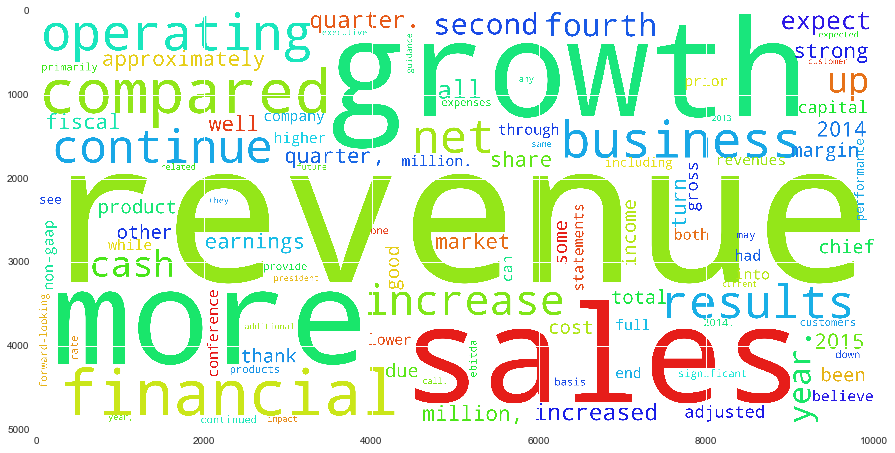

Mid


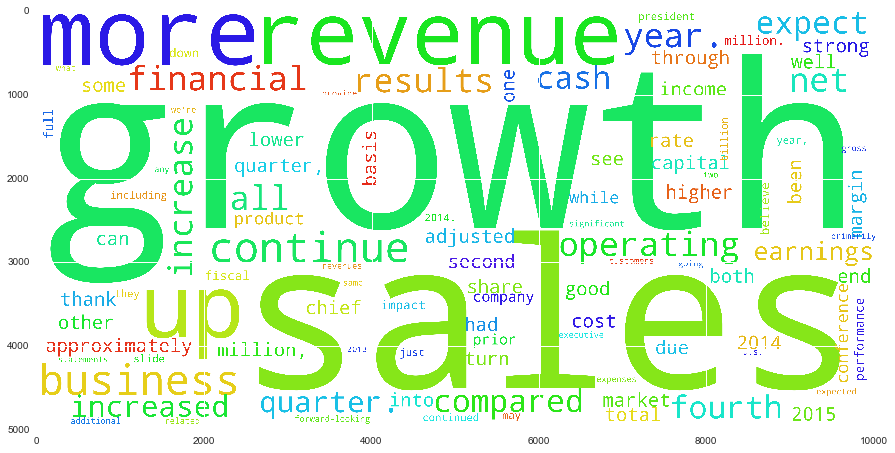

Low


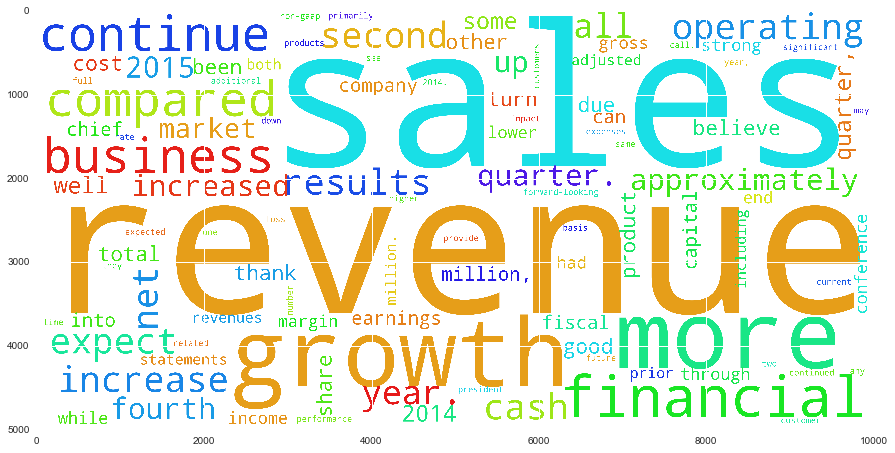

In [8]:
# Generates a word cloud for each tier (High/Mid/Low) with the 100 most common non-stop words
for key in tiers.keys():
    tier = TranscriptDoc(tiers[key])
    cloud = WordCloud(scale=25, background_color='white').generate_from_frequencies(Counter(tier).most_common(100))
    fig = plt.imshow(cloud, aspect='auto')
    fig = plt.gcf()
    fig.set_size_inches(15,7.5)
    print key
    plt.show()

In [9]:
def tokenize_text(tiers):
    
    """ Tokenizes the words of every transcript """
    
    for key in tiers.keys():
        
        tier = tiers[key]
        print key,

        for i, transcript in enumerate(tier):
            tier[i] = transcript.prepared.apply(word_tokenize)
        
        print len(tier)
        tiers[key] = tier

    return tiers

In [10]:
tiers = tokenize_text(tiers)

High 2766
Mid 22482
Low 2898


In [11]:
def common_ngrams(tiers, n=2, freq_filter=100, size=15, return_ngrams=False):
    
    for key in tiers.keys():
        
        print key
        text = tiers[key]
        
        words = []
        for transcript in text: 
            transcript.apply(words.__iadd__)

        if n == 2:
            finder = BigramCollocationFinder.from_words(words)
            ngram_measures = nltk.collocations.BigramAssocMeasures()
        elif n == 3:
            finder = TrigramCollocationFinder.from_words(words)
            ngram_measures = nltk.collocations.TrigramAssocMeasures()
        else:
            raise ValueError('Invalid input for n: {}'.format(n))
        
        finder.apply_freq_filter(freq_filter)
        finder.apply_word_filter(lambda w: w[0] == w[0].upper())
        finder.apply_ngram_filter(filter_ngrams)
        
        nbest = finder.score_ngrams(ngram_measures.pmi)[:size]
        ngrams, scores = zip(*nbest)
        ngrams = [''.join((word + ' ') for word in ngram) for ngram in ngrams]
        df = pd.DataFrame({'ngram': [ngram[:-1] for ngram in ngrams], 'score': scores}).sort_values(by='score', ascending=True)
        
        if return_ngrams: 
            return df
        
        df.plot(x='ngram', y='score', kind='barh', figsize=(10, 7), fontsize=12)
        plt.tight_layout()
        plt.show()

        
def filter_ngrams(w1,w2,w3=None):
    
    accepted = 'increased decreased up down flat negative positive growth strong weak good bad great best worst'.split()
    not_accepted = 'morning afternoon'
    ngram = (w1, w2, w3) if w3 else (w1, w2)
    flag = True
    
    for word in ngram:
        if word in not_accepted: return True
        elif word in accepted: flag = False
        else: continue
    return True if flag else False

High


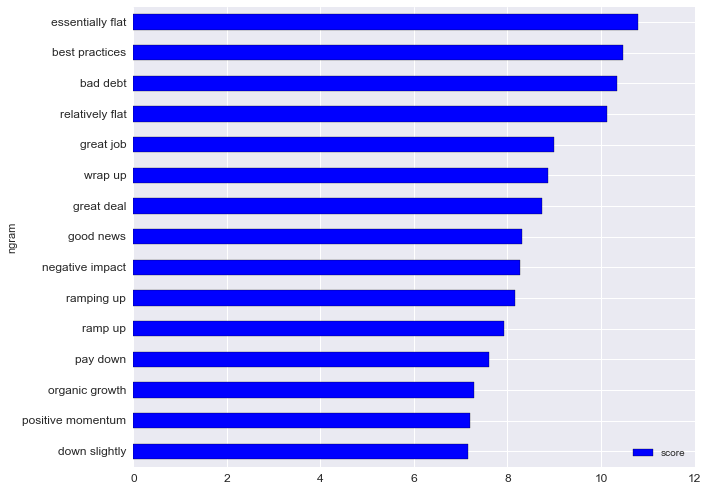

Mid


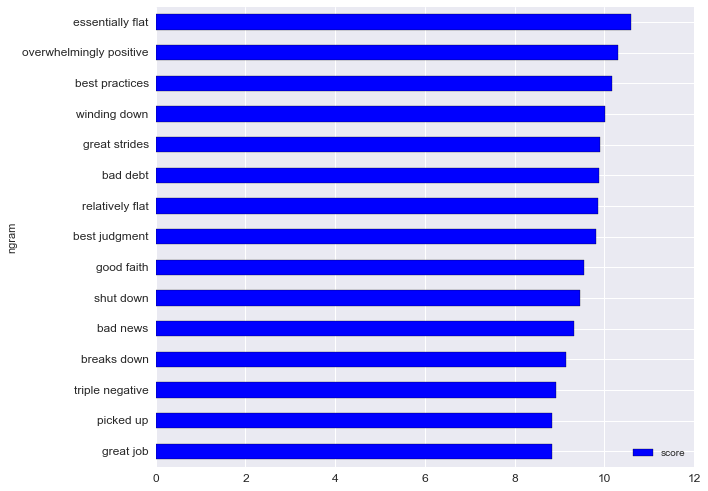

Low


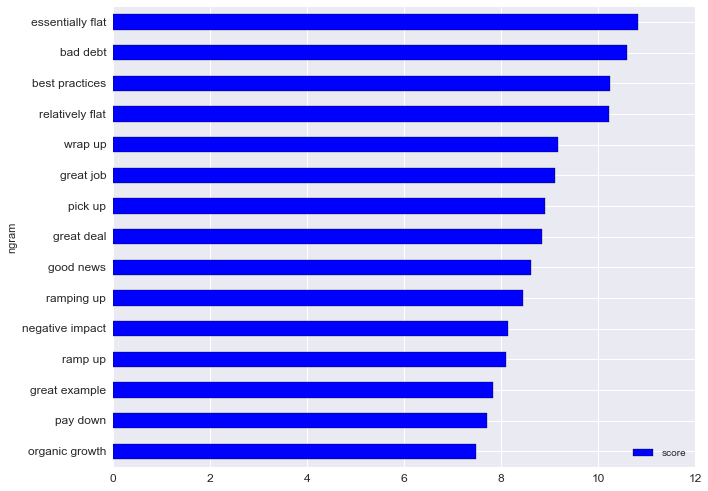

In [12]:
common_ngrams(tiers, n=2)

High


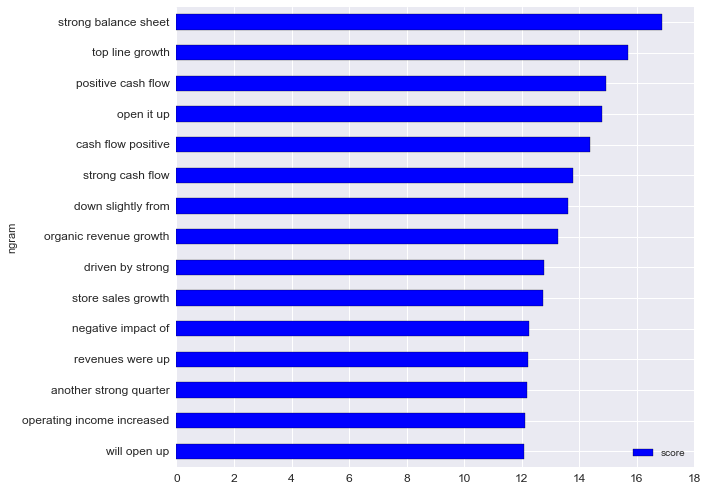

Mid


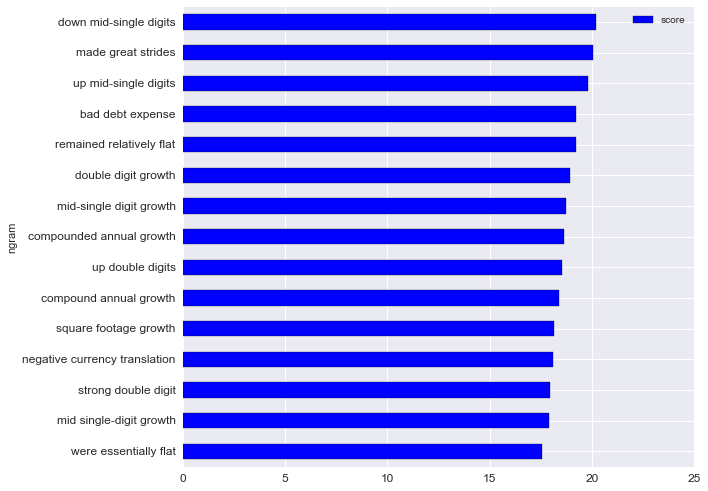

Low


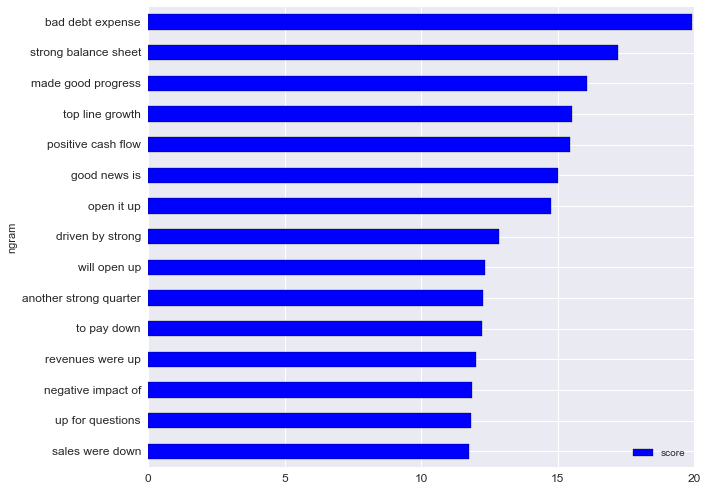

In [13]:
common_ngrams(tiers, n=3)

In [14]:
all_tiers = []
all_transcripts = {'all': all_tiers + x for x in tiers.values()}
df = common_ngrams(all_transcripts, n=3, freq_filter=100, size=50, return_ngrams=True)

all


In [15]:
def build_matrix(transcripts, ngrams):
    
    """ Builds a co-occurrence matrix between ticker symbols and common 3-grams """
    
    matrix = {}
    
    for ngram in ngrams:

        running_list = {}
        
        for transcript in transcripts.values():
            
            count = sum(transcript.prepared.map(lambda x: 1 if ngram in x else 0))
            
            try:
                running_list[transcript.ticker] += count
            except KeyError:
                running_list[transcript.ticker] = count   
        
        matrix[ngram] = running_list
    
    return matrix

In [16]:
matrix = build_matrix(transcripts, df.ngram)

In [21]:
def plot_matrix(matrix):
    
    """ Plots the co-occurrence matrix """
    
    ngrams, data = zip(*matrix.items())
    
    # Create dataframe with index as tickers in alphabetical order
    index = sorted(data[0].keys())
    df = pd.DataFrame(index=index)

    for i, ngram in enumerate(ngrams):
        tickers, counts = zip(*sorted(data[i].items(), key=lambda x: x[0]))
        if list(df.index) == list(tickers):
            df[ngram] = counts
        else: 
            print 'Values for "{}" in incorrect order!'.format(ngram)
    
    # Plot co-occurrence matrix with top 50 companies that use the ngrams
    top_50 = df.sum(axis=1).sort_values(ascending=False).index[:50]
    df = df.ix[top_50]

    fig = sb.heatmap(df, linewidths=.5)
    fig = plt.gcf()
    fig.set_size_inches(20,15)
    plt.show()

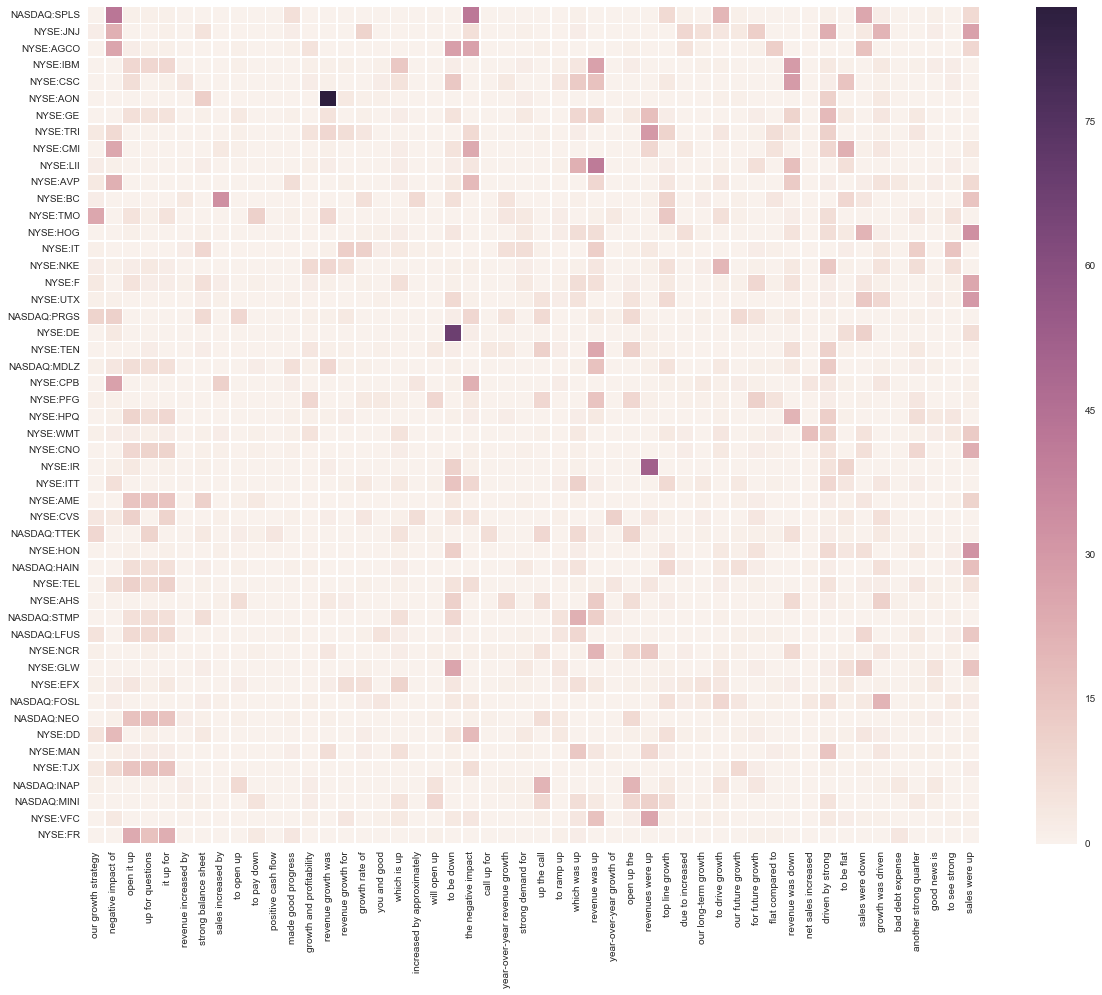

In [22]:
plot_matrix(matrix)